# Finding the right model

In [101]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.functions import load_OU_data, CourseScaler, plot_confusion, score_grid, \
smotecourses, process_courses, course_cross_validate, Course_GridSearchCV

import pickle

import warnings

from IPython.display import display

warnings.filterwarnings("ignore")
sns.set_style('white')
pd.set_option('display.max_columns',None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
def cross_val_presentation(model, df, show_scores = False, show_progress = False):
    
    index = df.groupby(by=['code_module','code_presentation']).count().index
    scores = pd.DataFrame(columns = ['accuracy'], index = index)
    for module in df['code_module'].unique():
        df_course = df[df['code_module'] == module]
        for presentation in df_course['code_presentation'].unique():
            train = df[(df['code_module'] != module) | (df['code_presentation'] != presentation)]
            test = df[(df['code_module'] == module) & (df['code_presentation'] == presentation)]
            if module in train['code_module'].unique():
                score = model_evaluate_presentation(model, train, test)
                scores.loc[(module,presentation), 'accuracy'] = score
                if show_progress:
                    print((module,presentation))
            else:
                scores.loc[(module,presentation), 'accuracy'] = np.nan
    if show_scores:
        display(scores.accuracy.mean())
    return scores
    
def model_evaluate_presentation(model, train, test):

    X_train = train.drop(columns = ['id_student','code_presentation','region','highest_education', \
                       'imd_band','gender','age_band','disability','studied_credits',
                       'module_presentation_length','date_registration','final_result'])
    y_train = train['final_result']
    X_test = test.drop(columns = ['id_student','code_presentation','region','highest_education', \
                       'imd_band','gender','age_band','disability','studied_credits',
                       'module_presentation_length','date_registration','final_result'])
    y_test = test['final_result']

    transformed_big_data = process_courses(X_train, y_train, X_test, y_test)
    X_train_transformed, y_train_transformed, X_test_transformed, y_test = transformed_big_data
    model.fit(X_train_transformed, y_train_transformed)
    y_pred = model.predict(X_test_transformed)
    return accuracy_score(y_test, y_pred)

In [83]:
df_full = load_OU_data(prediction_window=.5)


In [119]:
df = df_full.copy()
df['final_result'] = np.array(['No Intervention' if w in ['Pass','Distinction'] \
              else 'Needs Intervention' for w in df['final_result']])
test_df = df[df['code_presentation'] == '2014J']
train_df = df[df['code_presentation'] != '2014J']
X_test = test_df.drop

# Todo:
1. data_prep() function
2. X_test, y_test (holdout)

In [124]:
train_df.groupby(by=['code_module','code_presentation']).count()

id_student  gender  region  highest_education  \
code_module code_presentation                                                  
AAA         2013J                     338     338     338                338   
BBB         2013B                    1363    1363    1363               1363   
            2013J                    1681    1681    1681               1681   
            2014B                    1181    1181    1181               1181   
CCC         2014B                    1137    1137    1137               1137   
DDD         2013B                     947     947     947                947   
            2013J                    1392    1392    1392               1392   
            2014B                     846     846     846                846   
EEE         2013J                     818     818     818                818   
            2014B                     543     543     543                543   
FFF         2013B                    1231    1231    1231               1231   
            2013J                    1671    1671    1671               1671   
            2014B                    1106    1106    1106               1106   
GGG         2013J                     907     907     907                907   
            2014B                     774     774     774                774   

                               imd_band  age_band  num_of_prev_attempts  \
code_module code_presentation                                             
AAA         2013J                   338       338                   338   
BBB         2013B                  1363      1363                  1363   
            2013J                  1681      1681                  1681   
            2014B                  1181      1181                  1181   
CCC         2014B                  1137      1137                  1137   
DDD         2013B                   947       947                   947   
            2013J                  1392      1392                  1392   
            2014B                   846       846                   846   
EEE         2013J                   818       818                   818   
            2014B                   543       543                   543   
FFF         2013B                  1231      1231                  1231   
            2013J                  1671      1671                  1671   
            2014B                  1106      1106                  1106   
GGG         2013J                   907       907                   907   
            2014B                   774       774                   774   

                               studied_credits  disability  final_result  \
code_module code_presentation                                              
AAA         2013J                          338         338           338   
BBB         2013B                         1363        1363          1363   
            2013J                         1681        1681          1681   
            2014B                         1181        1181          1181   
CCC         2014B                         1137        1137          1137   
DDD         2013B                          947         947           947   
            2013J                         1392        1392          1392   
            2014B                          846         846           846   
EEE         2013J                          818         818           818   
            2014B                          543         543           543   
FFF         2013B                         1231        1231          1231   
            2013J                         1671        1671          1671   
            2014B                         1106        1106          1106   
GGG         2013J                          907         907           907   
            2014B                          774         774           774   

                               date_registration  module_presentation_length  \
code_module code_pres

('BBB', '2013B')
('BBB', '2013J')
('BBB', '2014B')
('DDD', '2013B')
('DDD', '2013J')
('DDD', '2014B')
('EEE', '2013J')
('EEE', '2014B')
('FFF', '2013B')
('FFF', '2013J')
('FFF', '2014B')
('GGG', '2013J')
('GGG', '2014B')


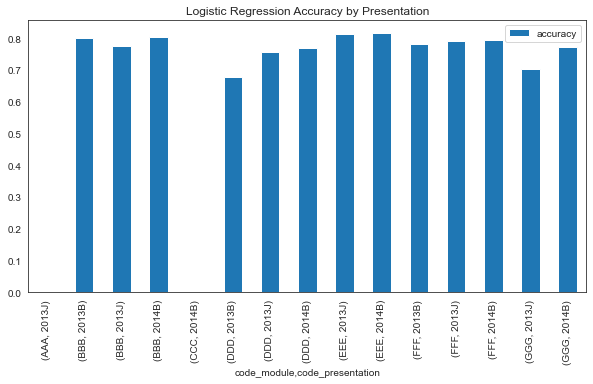

In [126]:

model = LogisticRegression()
scores = cross_val_presentation(model, train_df, show_scores = False, show_progress=True)
scores.plot(kind = 'bar', figsize = (10,5), title = 'Logistic Regression Accuracy by Presentation')
plt.show()


In [109]:
model = XGBClassifier()
cross_val_presentation(model, df, show_scores = False, show_progress = True)

0.759112184606397

In [111]:
model = pickle.load(open('../models/XGBmodel4.pkl','rb'))
cross_val_presentation(model, df, show_scores = False, show_progress = True)

('AAA', '2013J')
('AAA', '2014J')
('BBB', '2013B')
('BBB', '2013J')
('BBB', '2014B')
('BBB', '2014J')
('CCC', '2014B')
('CCC', '2014J')
('DDD', '2013B')
('DDD', '2013J')
('DDD', '2014B')
('DDD', '2014J')
('EEE', '2013J')
('EEE', '2014B')
('EEE', '2014J')
('FFF', '2013B')
('FFF', '2013J')
('FFF', '2014B')
('FFF', '2014J')
('GGG', '2013J')
('GGG', '2014B')
('GGG', '2014J')


0.7613645869842576

In [69]:
X_val_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4450 entries, 3706 to 23206
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   num_of_prev_attempts      4450 non-null   float64
 1   days_studied              4450 non-null   float64
 2   activities_engaged        4450 non-null   float64
 3   total_clicks              4450 non-null   float64
 4   assessments_completed     4450 non-null   float64
 5   average_assessment_score  4450 non-null   float64
dtypes: float64(6)
memory usage: 243.4 KB


In [70]:
len(y_val)

4450

# CourseScaler class and smotecourses() function
We run into a problem with our data because this dataset comprises 7 different courses and each course has different numbers of activities, assessments, and demands different amounts of work.  This creates a variable in the data which is unrelated to the actual student activity or effort, but is intrinsic in the course itself.  We can partially over come this, making our model more general, by normalizing the activity statistics for each course.  In other words, while 100 activities may be sufficient to succeed in course A, 200 activities may be necessary for course B.  Instead, we take the mean of all students' activitiy counts and divide by the standard deviation.  Now the necessary activities for course A and B are set to the same value, more or less.  

This is what the `CourseScaler` transformer does. It can fit on and transform the training data and then use the mean and standard deviation from the training data to transform the test data on the same scale.

But, different courses don't also have different work requirements, they also have different success rates, which will also bias the predictions.  The solution is to balance the classes in each course to remove this bias as well, which is what the function `smotecourses()` does.  SMOTE is a class from [Imbalanced Learn](https://imbalanced-learn.org/stable/index.html) which creates synthetic data as a way of upsampling a minority class without directly duplicating observations.  It uses a K-neartest neighbors approach to create new observations with very similar features to others.  Once the minority class is smoted, the classes are balanced in each course and the bias is removed.  For the purposes of training our model, each course has the same graduation rate and requires the same level of effort and grades assessments on the same scale.  See the readme for a more on why this is important.

I wrap these into the `process_courses()` function, which returns scaled and smoted training set and a test set scaled on the CourseScaler fitted on the train set (but not smoted)

With these solutions we can overcome the bias that different courses would have otherwise introduced into our dataset.

# When do we transform?
We are going to create transformed versions of the above datasets for use in evaluating models.  However our custom course_cross_validate function will automatically perform these transformations on each cross-validation fold during it's hyperparameter search to prevent data leakage during cross validation.  When we cross-validate models we will only give them the X_t and y_t datasets.

# FSM
A decent start for a baseline model, a logistic regresson model seeks the best fit line to model the linear relationship between the predictor variables, X, and the target variable, y, which is a linear regression. It then applies a sigmoid function to that line to assign probabilities that each observation belongs in one class or the other.  For our purposes, if the probability of an observation belonging a class is greater than .5, then we will predict that it belongs to that class.  We will use our custom cross_validate function to remove the course bias.

In [71]:
lr = LogisticRegression()

scores = course_cross_validate(lr,X_t,y_t,scoring='accuracy', cv=cv, random_state = 111)

print(scores)
print('Mean cross validated accuracy:')
print(np.mean(scores))
lr.fit(X_t, y_t)
y_pred = lr.predict(X_val_transformed)
print('validation accuracy: ')
print(accuracy_score(y_val, y_pred))
plot_confusion(y_val, y_pred, cmap='Greens', save_path='../figures/FSMconfusionmatrix.png')
pickle.dump(lr,open('../models/FSM2.pkl','wb'))
print(lr)

[0.7724637681159421, 0.7830917874396135, 0.7864734299516908, 0.7805703238279362, 0.7849202513291446]
Mean cross validated accuracy:
0.7815039121328654


ValueError: could not convert string to float: 'AAA'

### Evaluation
The FSM achieves 73.6% accuracy with a good balance between course predictions.  This is a lovely start, but let's see if we can do better.

## GridsearchCV for best logistic regression hyperparameters

In [ ]:
LRparams = [{'solver': ['lbfgs','sag','saga','newton-cg'],
         'penalty': ['none'],
         'random_state':[111]},
          {'solver': ['lbfgs','sag','saga','newton-cg','liblinear'],
         'penalty': ['l2'],
         'random_state':[111]},
          {'solver':['saga'],
          'penalty':['elasticnet'], 'l1_ratio':[.1,.5,.7]},
          {'solver':['saga','liblinear'],
          'penalty':['l1']}]


LRgrid = Course_GridSearchCV(LogisticRegression(), LRparams, cv=cv, 
                                scoring='accuracy', verbose = False)

LRgrid.fit(X_t, y_t)
LRmodel = score_grid(LRgrid, X_val_transformed, y_val)
pickle.dump(LRmodel,open('../models/LRmodel2.pkl','wb'))

## Logistic Regression Evaluation
By optimizing the hyperparameters of the logistic regression model, which are all regularization parameters, we've barely moved the needle at all.  We gained .0002 accuracy.

# More model types
We used the logistic regression classifier to tune our features, but now it's time to try some other models.  We will use Course_GridsearchCV to optimize the hyperparameters for these as well.

# Decision Tree
A decision tree is a promising candidate for this problem because it does not assume the independence of the features. Instead it seeks to find the best way to divide and subdivide the data in a tree structure based on the values of different variables.  We can tune how many features each split is allowed to consider.  Once the tree is build predictions are made by sending an observations down the tree sending it on a path to the predicted class as it reaches each split in the tree is sent in one or the other direction.  You can think of it like a deterministic Pachinko machine!

In [ ]:
DTparams = {'criterion':['gini','entropy'],
           'splitter':['best','random'],
           'max_depth':[4,10],'min_samples_split':[.01,.1,.2,.5],
           'max_features':[1,2,3,4,5],'random_state':[111]}
           
DTgrid = Course_GridSearchCV(DecisionTreeClassifier(), DTparams, cv=cv, scoring = 'accuracy')

DTgrid.fit(X_t, y_t)

DTmodel = score_grid(DTgrid, X_val_transformed, y_val, cmap = 'Greens')
plt.savefig('../figures/DTconfmatrix.png',dpi=250)
pickle.dump(DTmodel,open('../models/DTmodel2.pkl','wb'))

### Decision Tree Evaluation 
As expected, this model is better at predicting how a student will do.  It doesn't rely on establishing a straight line through the data to model it, which is probably not the best approach in this problem space.  We see a nice increase in accuracy here.

# Random Forest Classifier
This is an interesting extension to the decision tree model.  It creates a whole forest of decision trees and trains each one on a subset of the data and a subset of the features.  This is a technique called bagging, or [Boostrap AGGregation](https://machinelearningmastery.com/bagging-and-random-forest-ensemble-algorithms-for-machine-learning/) (check the link for more on this).  It works on the principle that a bunch of bad predictors, on average will be more accurate than one good predictor.  This worked for Francis Galton in [guessing the weight of an ox](https://crowdsourcingweek.com/blog/using-the-crowd-to-predict/), maybe it will work here!

In [ ]:
RFparams = {'n_estimators':[10,100,150],
           'criterion':['gini','entropy'],
           'max_depth':[4],
           'min_samples_split':[2,4,5],
           'oob_score':[True,False],
           'n_jobs':[-1],'random_state':[111],
           'max_samples':[.5,.7,None]}
           
RFgrid = Course_GridSearchCV(RandomForestClassifier(), RFparams, cv=cv)

RFgrid.fit(X_t, y_t)

RFmodel = score_grid(RFgrid, X_val_transformed, y_val, save_path = '../figures/RFmodel2confmatrix.png')
pickle.dump(RFmodel, open('../models/RFmodel2.pkl','wb'))

### Random Forest Classifier Evaluation:
Apparently bagging is not the right approach to this problem.  Our single well tuned decision tree outperformed the random forest classifier.  I guess the wisdom of the crowd is not always superior to the wisdom of the expert!

# eXtreme Gradient Boost model:
XGBoost models have gained a lot of popularity recently and won a lot of Kaggle competitions.  It uses another popular idea called [boosting](https://en.wikipedia.org/wiki/Gradient_boosting).  That's a pretty involved wikipedia article, but the TLDR is that it's a similar ensemble method like random forest, but whereas random forest trains a bunch of trees in parallel and takes the aggregate of their predictions, boosting stacks the trees on top of each other and each one tries to improve on the one below it by predicting where the previous one made mistakes.  I think of it as like a line of morons each grading the next one's paper, which is an analysis of the previous one's paper.  Each one gets a lot wrong, but something right so the right answers percolate through and some of the wrong answers get corrected at each step.

In [ ]:
XGBparams = {'n_estimators':[150,200],
             'max_depth':[4],
             'learning_rate':[.1], 
             'subsample':[.7],
             'gamma':[0,1],
             'min_child_weight':[1,2],
             'num_parallel_tree':[1,2],
             'eval_metric':['error','logloss'],
            'colsample_bytree':[.6,.7,.8],
            'base_score':[.1,.2,.4]}
           
XBGgrid = Course_GridSearchCV(XGBClassifier(objective='binary:logistic', n_jobs=-1, random_state=111),
                         XGBparams, cv=cv)
XBGgrid.fit(X_t, y_t)

XGBmodel = score_grid(XBGgrid, X_val_transformed, y_val, 
                     save_path = '../figures/XGBmodelconfmatrix4.png')
pickle.dump(XGBmodel, open('../models/XGBmodel4.pkl','wb'))

## XGBoost evaluation:
XGBoost gave us the best cross-validated score of these four model types.  While it performs slightly worse on the validation set than the random forest, looking at the scores across folds, it seems likely that this represents the validation set being a sort of bad split.  XGBoost also performs equally well on both classes.  It correctly identifies 74% of students who need intervention to succeed, while misclassifying 27% of passing students as needing intervention.  

# SVM
An SVM, or support vector machine, attempts to draw a line, or hyperplane, between the classes to divide them.  This can be degree 2 polynomial line or higher, creating curved dividers of different shapes to match more complex decision boundaries.  It finds the best fit such hyperplane so as to maximize the distance between observations in a recursive manner.  EDA suggests that the observations can, to a large extent, be divided along the variables we have seen.  Decision trees, which do not operate this way, have been relatively successful, but let's see what this model, somewhat more closely related to the logistic regression, can do.

In [ ]:
SVCparams = {'C':[.01],
            'kernel':['linear',],
             'gamma':['auto'],
             'tol':[1e-3],}
             
SVCgrid = Course_GridSearchCV(SVC(random_state=111), SVCparams, cv=cv, 
                                scoring='accuracy', verbose = True)

SVCgrid.fit(X_t, y_t)
SVCmodel = score_grid(SVCgrid, X_val_transformed, y_val)
pickle.dump(SVCmodel, open('../models/SVCmodel1.pkl','wb'))

## SVM Evaluation
The SVM performed quite well.  It scored an overall accuracy of 77% with slight prediction bias toward 'No Intervention', in line with the other models.  

Different hyper parameters didn't make much difference to accuracy, except a polynomial kernel (degree 3) over predicted student success.  This would be the way to go if interventions are particularly costly.  If you biased the predictions that much toward 'No Intervention', you could be fairly certain that the students receiving interventions really need them.  The same results could also be achieved with the logistic regression model by setting the decision point of the sigmoid function toward the passing class, biasing the model.

## K-Nearest Neighbors
This model positions each observation (student registration in this case) from the training set in n_feature dimensional space.  New observations from the test set are voted on by the closest K observations from the training set to determine which class the new observation should belong to. There are two big benefits to this modeling technique for our dataset.  The first is that it is fast with few features.  We have only 6 features, so the dimensionality of the space is low, observations are more tightly packed, and the model makes determinations quickly.  The second benefit is that it is non-linear.  We've had some success with more linear models, and decision tree models.  Our error analysis and EDA show that there are strong linear relationships between our variables and the success of students.  However there is a solid 20% of students that cannot seem to be classified with these linear models.  The decision tree models similar seem to fail to classify these students.  Perhaps this model can help find where they belong.  

In [ ]:
KNNparams = {'n_neighbors':[30, 50, 100, 150],
            'weights':['distance'],
             'p':[6, 7, 8, 9],
             'n_jobs':[-1],}
             
KNNgrid = Course_GridSearchCV(KNeighborsClassifier(), KNNparams, cv=cv, 
                                scoring='accuracy', verbose = False)

KNNgrid.fit(X_t, y_t)
KNNmodel = score_grid(KNNgrid, X_val_transformed, y_val)
pickle.dump(KNNmodel, open('../models/KNNmodel1.pkl','wb'))

### KNN Evaluation
This model, like the others, seems to top out around 77%.  We still haven't found a way to capture the pattern for how those last 20-23% of students fail or withdraw.  Looking at our error analysis from the final report notebook we see that those misclassfied students really look a lot like successful ones according to all of our variables.  It may just be that we don't have the right variable to find the connection.  We may be running up against the irreducible error for this feature set.

# Final Model:
Our XGboost model performed the best here, so lets give it the whole training set to learn from and see how it does on our hold-out test set.

In [ ]:
final_model = pickle.load(open('../models/XGBmodel4.pkl','rb'))

final_model.fit(X_train_transformed, y_train_transformed)
y_pred = final_model.predict(X_test_transformed)
print('Final Model')
print(final_model)
print('Final Model Classification Report')
print(classification_report(y_test, y_pred))
print('Final Model Confusion Matrix')
plot_confusion(y_test, y_pred, save_path='../figures/final_modelconfmatrix.png')

## Final Model Evaluation:
Our final model, the XGBoost, does pretty well on the test set.  We could have hoped for more, but this is pretty good.  It identifies almost 80% of students in danger of who will do fine while misclassifying a little more than a quarter of students needing interventions.  This may not be ready for deployment, but I believe it serves as a solid proof of concept that student success can be, in many cases, predicted by their interactions with a virtual learning environment.  The difference in different models was, for the most part, quite small.  The XGBoost only won out by 2% accuracy.

In [ ]:
RFmodel.fit(X_train_transformed,y_train_transformed)
y_pred = RFmodel.predict(X_test_transformed)
plot_confusion(y_test, y_pred)
print(classification_report(y_test,y_pred))

In [ ]:
DTmodel.fit(X_train_transformed,y_train_transformed)
y_pred = DTmodel.predict(X_test_transformed)
plot_confusion(y_test, y_pred)
print(classification_report(y_test,y_pred))

In [ ]:
LRmodel.fit(X_train_transformed,y_train_transformed)
y_pred = LRmodel.predict(X_test_transformed)
plot_confusion(y_test, y_pred)
print(classification_report(y_test,y_pred))

In [ ]:
SVCmodel.fit(X_train_transformed,y_train_transformed)
y_pred = SVCmodel.predict(X_test_transformed)
plot_confusion(y_test, y_pred)
print(classification_report(y_test,y_pred))

In [ ]:
XGBmodel.fit(X_train_transformed,y_train_transformed)
y_pred = XGBmodel.predict(X_test_transformed)
plot_confusion(y_test, y_pred)
print(classification_report(y_test,y_pred))

In [ ]:
KNNmodel.fit(X_train_transformed,y_train_transformed)
y_pred = KNNmodel.predict(X_test_transformed)
plot_confusion(y_test, y_pred)
print(classification_report(y_test,y_pred))